In [1]:
# Create the environment and install required packages
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# Imports
import os
import glob
import json
import numpy as np
import keras
from enum import Enum
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from random import randrange
import random
import math
import pypianoroll
from utils.midi_utils import play_midi, plot_pianoroll, get_music_metrics, process_pianoroll, process_midi
from constants import Constants
from augmentation import AddAndRemoveAPercentageOfNotes
from data_generator import PianoRollGenerator
from utils.generate_training_plots import GenerateTrainingPlots
from inference import Inference
from model import OptimizerType
from model import ArCnnModel

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### The dataset is a set of Blues MIDI tracks, usually established standards by Blues legends such as B.B.King, Howlin' Wolf, John Lee Hooker etc, or standard 12-bar blues forms. The rationale is that these will help the model learn the typical Blues pattern. 

In [3]:
# !unzip data/blues_midi_3.zip -d data

In [4]:
#Import the MIDI files from the data_dir and save them with the midi_files variable  
data_dir = 'data/*.midi'
midi_files = glob.glob(data_dir)
len(midi_files)

70

In [5]:
#Finds our random MIDI file from the midi_files variable and then plays it
#Note: To listen to multiple samples from the Blues dataset, you can run this cell over and over again. 
random_midi = randrange(len(midi_files))
play_midi(midi_files[random_midi])

Using 12 bars, since that is more akin to the usual structure of blues compositions

In [6]:
# Generate MIDI file samples
def generate_samples(midi_files, bars, beats_per_bar, beat_resolution, bars_shifted_per_sample):
    """
    dataset_files: All files in the dataset
    return: piano roll samples sized to X bars
    """
    timesteps_per_nbars = bars * beats_per_bar * beat_resolution
    time_steps_shifted_per_sample = bars_shifted_per_sample * beats_per_bar * beat_resolution
    samples = []
    for midi_file in midi_files:
        pianoroll = process_midi(midi_file, beat_resolution) # Parse the MIDI file and get the piano roll
        samples.extend(process_pianoroll(pianoroll, time_steps_shifted_per_sample, timesteps_per_nbars))
    return samples

In [7]:
# Saving the generated samples into a dataset variable 
dataset_samples = generate_samples(midi_files, Constants.bars, Constants.beats_per_bar,Constants.beat_resolution, Constants.bars_shifted_per_sample)
# Shuffle the dataset
random.shuffle(dataset_samples);

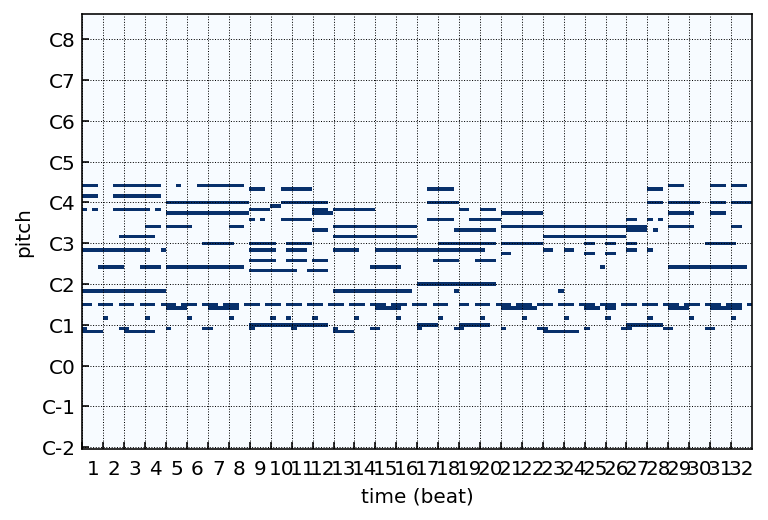

In [8]:
# Visualize a random piano roll from the dataset 
random_pianoroll = dataset_samples[randrange(len(dataset_samples))]
plot_pianoroll(pianoroll = random_pianoroll,
               beat_resolution = 4)

In [9]:
sampling_lower_bound_remove = 0 
sampling_upper_bound_remove = 100
sampling_lower_bound_add = 1
sampling_upper_bound_add = 1.5

In [10]:
# Customized loss function
class Loss():
    @staticmethod 
    def built_in_softmax_kl_loss(target, output):
        '''
        Custom Loss Function
        :param target: ground truth values
        :param output: predicted values
        :return kullback_leibler_divergence loss
        '''
        target = K.flatten(target)
        output = K.flatten(output)
        target = target / K.sum(target)
        output = K.softmax(output)
        return keras.losses.kullback_leibler_divergence(target, output)

In [11]:
dataset_size = len(dataset_samples)
dataset_split = math.floor(dataset_size * Constants.training_validation_split) 

training_samples = dataset_samples[0:dataset_split]
print("training samples length: {}".format(len(training_samples)))
validation_samples = dataset_samples[dataset_split + 1:dataset_size]
print("validation samples length: {}".format(len(validation_samples)))

training samples length: 1058
validation samples length: 117


In [12]:
# Piano Roll Input Dimensions
input_dim = (Constants.bars * Constants.beats_per_bar * Constants.beat_resolution, 
             Constants.number_of_pitches, 
             Constants.number_of_channels)
# Number of Filters In The Convolution
num_filters = 32
# Growth Rate Of Number Of Filters At Each Convolution
growth_factor = 2
# Number Of Encoder And Decoder Layers
num_layers = 5
# A List Of Dropout Values At Each Encoder Layer
dropout_rate_encoder = [0, 0.5, 0.5, 0.5, 0.5]
# A List Of Dropout Values At Each Decoder Layer
dropout_rate_decoder = [0.5, 0.5, 0.5, 0.5, 0]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Encoder
batch_norm_encoder = [True, True, True, True, False]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Decoder
batch_norm_decoder = [True, True, True, True, False]
# Path to Pretrained Model If You Want To Initialize Weights Of The Network With The Pretrained Model
pre_trained = False
# Learning Rate Of The Model
learning_rate = 0.001
# Optimizer To Use While Training The Model
optimizer_enum = OptimizerType.ADAM
# Batch Size
batch_size = 64
# Number Of Epochs
epochs = 50

In [13]:
# The Number of Batch Iterations Before A Training Epoch Is Considered Finished
steps_per_epoch = int(
    len(training_samples) * Constants.samples_per_ground_truth_data_item / int(batch_size))

print("The Total Number Of Steps Per Epoch Are: "+ str(steps_per_epoch))

# Total Number Of Time Steps
n_timesteps = Constants.bars * Constants.beat_resolution * Constants.beats_per_bar

The Total Number Of Steps Per Epoch Are: 132


In [14]:
## Training Data Generator
training_data_generator = PianoRollGenerator(sample_list=training_samples,
                                             sampling_lower_bound_remove = sampling_lower_bound_remove,
                                             sampling_upper_bound_remove = sampling_upper_bound_remove,
                                             sampling_lower_bound_add = sampling_lower_bound_add,
                                             sampling_upper_bound_add = sampling_upper_bound_add,
                                             batch_size = batch_size,
                                             bars = Constants.bars,
                                             samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                             beat_resolution = Constants.beat_resolution,
                                             beats_per_bar = Constants.beats_per_bar,
                                             number_of_pitches = Constants.number_of_pitches,
                                             number_of_channels = Constants.number_of_channels)

# Validation Data Generator
validation_data_generator = PianoRollGenerator(sample_list = validation_samples,
                                               sampling_lower_bound_remove = sampling_lower_bound_remove,
                                               sampling_upper_bound_remove = sampling_upper_bound_remove,
                                               sampling_lower_bound_add = sampling_lower_bound_add,
                                               sampling_upper_bound_add = sampling_upper_bound_add,
                                               batch_size = batch_size, 
                                               bars = Constants.bars,
                                               samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                               beat_resolution = Constants.beat_resolution,
                                               beats_per_bar = Constants.beats_per_bar, 
                                               number_of_pitches = Constants.number_of_pitches,
                                               number_of_channels = Constants.number_of_channels)

In [15]:
# Callback For Loss Plots 
plot_losses = GenerateTrainingPlots()
## Checkpoint Path
checkpoint_filepath =  'checkpoints/-best-model-epoch:{epoch:04d}.hdf5'

# Callback For Saving Model Checkpoints 
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Create A List Of Callbacks
callbacks_list = [plot_losses, model_checkpoint_callback]

# Create A Model Instance
MusicModel = ArCnnModel(input_dim = input_dim,
                        num_filters = num_filters,
                        growth_factor = growth_factor,
                        num_layers = num_layers,
                        dropout_rate_encoder = dropout_rate_encoder,
                        dropout_rate_decoder = dropout_rate_decoder,
                        batch_norm_encoder = batch_norm_encoder,
                        batch_norm_decoder = batch_norm_decoder,
                        pre_trained = pre_trained,
                        learning_rate = learning_rate,
                        optimizer_enum = optimizer_enum)

model = MusicModel.build_model()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0

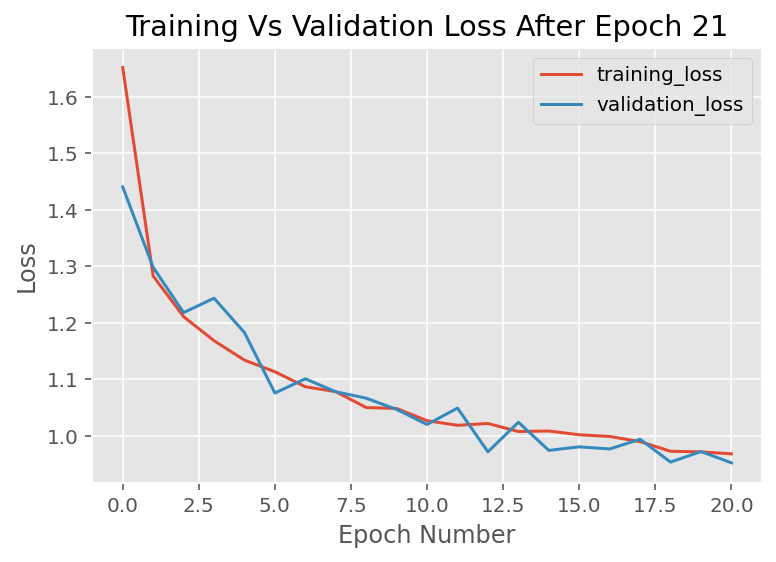

Epoch 22/50
 35/132 [======>.......................] - ETA: 7:28 - loss: 0.9700

In [ ]:
# Start Training
history = model.fit_generator(training_data_generator,
                              validation_data = validation_data_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              callbacks = callbacks_list)

In [17]:
# Load The Inference-Related Parameters
with open('inference_parameters.json') as json_file:
    inference_params = json.load(json_file)

In [18]:
!ls -ltr checkpoints/

total 7744804
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 01:38 -best-model-epoch:0001.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 01:48 -best-model-epoch:0002.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 01:57 -best-model-epoch:0003.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 02:17 -best-model-epoch:0005.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 02:27 -best-model-epoch:0006.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 02:57 -best-model-epoch:0009.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 03:07 -best-model-epoch:0010.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 03:16 -best-model-epoch:0011.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 03:36 -best-model-epoch:0013.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 04:36 -best-model-epoch:0019.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 04:55 -best-model-epoch:0021.hdf5
-rw-rw-r-- 1 ec2-user ec2-user 377648536 Aug 11 05:05 -best-model-epoch:0022.hdf5
-r

In [19]:
# Create An Inference Object
inference_obj = Inference()
# Load The Checkpoint
checkpoint_var = 'checkpoints/-best-model-epoch:0046.hdf5'
inference_obj.load_model(checkpoint_var)

In [20]:
# Generate The Composition
input_melody = 'sample_inputs/ode_to_joy.midi'  
inference_obj.generate_composition(input_melody, inference_params)

In [21]:
!ls -ltr outputs/

total 4
-rw-rw-r-- 1 ec2-user ec2-user 363 Aug 11 12:59 output_0.mid


In [22]:
output_melody = 'outputs/output_0.mid'
play_midi(output_melody)

In [23]:
print("The input midi metrics are:")
get_music_metrics(input_melody, beat_resolution=4)

print("\n")
# Generated Output Midi Metrics:
print("The generated output midi metrics are:")
get_music_metrics(output_melody, beat_resolution=4)

The input midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 4                    | 0.570         | 15              | 61.018         |
+----------------------+---------------+-----------------+----------------+


The generated output midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 4                    | 0.549         | 15              | 63.433         |
+----------------------+---------------+-----------------+----------------+


In [24]:
# Convert The Input and Generated Midi To Tensors (a matrix)
input_pianoroll = process_midi(input_melody, beat_resolution=4)
output_pianoroll = process_midi(output_melody, beat_resolution=4)

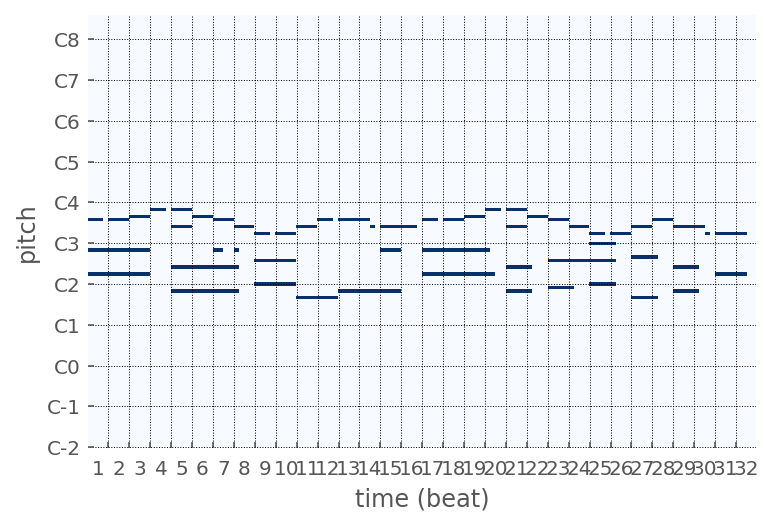

In [25]:
# Plot Input Piano Roll
plot_pianoroll(input_pianoroll, beat_resolution=4)

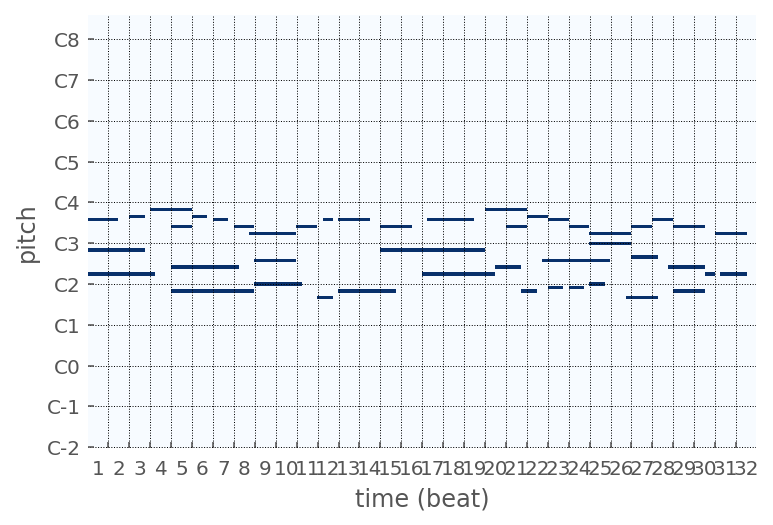

In [26]:
# Plot Output Piano Roll
plot_pianoroll(output_pianoroll, beat_resolution=4)

In [27]:
# Generate The Composition
input_melody = 'sample_inputs/deck_the_halls.midi'  
inference_obj.generate_composition(input_melody, inference_params)

In [28]:
!ls -ltr outputs/

total 8
-rw-rw-r-- 1 ec2-user ec2-user 363 Aug 11 12:59 output_0.mid
-rw-rw-r-- 1 ec2-user ec2-user 328 Aug 11 13:00 output_1.mid


In [29]:
output_melody = 'outputs/output_1.mid'
play_midi(output_melody)